In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from datetime import timedelta, datetime

from read_db.read_clickhouse import connection


exp_params = {
    'exp_dt_from': datetime(2022,11,2),
    'exp_dt_to': datetime(2022,11,8),
    'control_id': 1,
    'treat_id': 2,
    'num_buckets': 500   
}


In [2]:
def get_data(exp_dt_from, exp_dt_to, control_id, treat_id, num_buckets):
    
    q = f"""SELECT 
        exp_group, user_id,
        sum(action='like')/sum(action='view') ctr, 
        xxHash64(user_id)%{num_buckets} as bucket_id
        
       FROM {connection['database']}.feed_actions 
       where toDate(time) between '{exp_dt_from.strftime('%Y-%m-%d')}' and '{exp_dt_to.strftime('%Y-%m-%d')}' 
       and exp_group in ({control_id},{treat_id}) 
       group by exp_group, user_id

       """
    
    df = pandahouse.read_clickhouse(q, connection=connection)
    bucket_df = df[['exp_group', 'bucket_id', 'ctr']]\
        .groupby(['exp_group', 'bucket_id'], as_index=False)\
        .median()
    
    return df, bucket_df

## После эксперимента

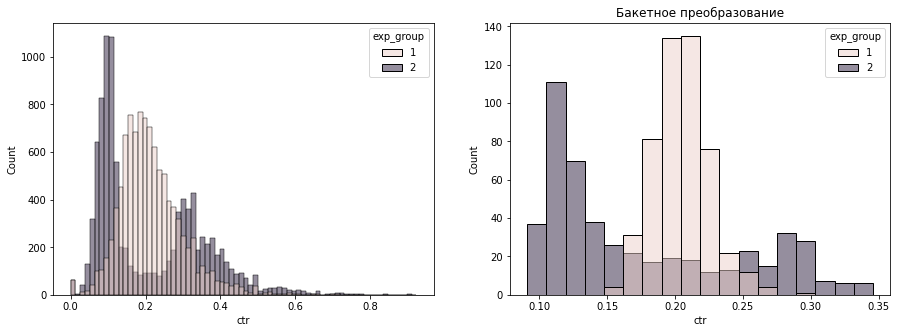

In [3]:
#читаем данные из бд
df, bucket_df = get_data(**exp_params)


# посмотрим на распредление CTR по группам
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(x='ctr', data=df, hue='exp_group', ax=ax[0])

# Распределение с бакетным преобразовнием 
ax[1].set_title('Бакетное преобразование')
sns.histplot(x='ctr', data=bucket_df, hue='exp_group', ax=ax[1])
plt.show()


## Проверим, что было за неделю до эксперимента. 
Предаврительно надо бы узнать, что в эти даты не проводилось других экспериментов( предположим эта информация изветсна)

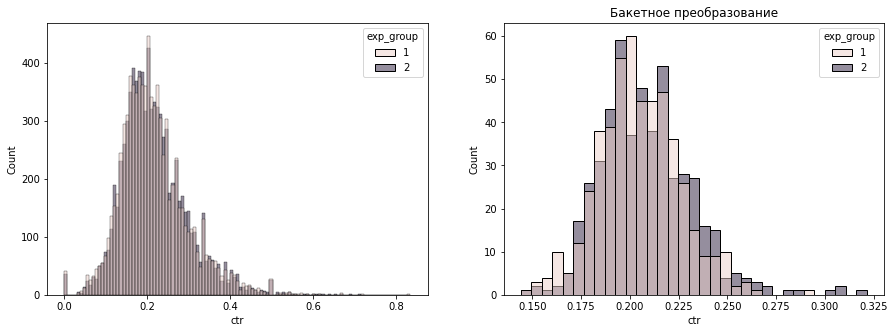

In [4]:
#читаем данные из бд

p = exp_params.copy()
p['exp_dt_from'] -= timedelta(days=7)
p['exp_dt_to'] -= timedelta(days=7)

df_lastweek, bucket_df_lastweek = get_data(**p)


# посмотрим на распредление CTR по группам
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(x='ctr', data=df_lastweek, hue='exp_group', ax=ax[0])

# Распределение с бакетным преобразовнием 
ax[1].set_title('Бакетное преобразование')
sns.histplot(x='ctr', data=bucket_df_lastweek, hue='exp_group', ax=ax[1])
plt.show()

## AB test

In [5]:
def stest(data, method = stats.mannwhitneyu, **kwargs):
    control = data.query(f"exp_group=={exp_params['control_id']}").ctr.values
    treat = data.query(f"exp_group=={exp_params['treat_id']}").ctr.values

    print(method(control,treat, **kwargs, ))



In [6]:
stest(df, alternative='two-sided', )

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


In [7]:
stest(bucket_df, alternative='two-sided')

MannwhitneyuResult(statistic=170323.5, pvalue=3.2448642324117504e-23)


In [8]:
stest(df, method= stats.ttest_ind, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)


In [9]:
stest(bucket_df, method= stats.ttest_ind, equal_var=False)

Ttest_indResult(statistic=8.929669770402166, pvalue=5.6174259865209736e-18)


# Вывод
1. Очевидно, что просто на пользовательских ctr применять ttest нельзя, так как распределение бимодальное. 

Использованные тесты:
* Мана Уитни на поюзерных ctr - различия статистически значимые.
* Мана Уитни на бакетах - различия статистически значимые.

* t-test на поюзерных ctr - нет статистически значимых различий. (проведен для доказательста первого тезиса)
* t-test на бакетах - различия статистически значимые.


2. В результате эксперимента группа, на которой опробовался новый алгоритм рекомендаций разделились еще на две группы:
* Рекомендации оказались релевантны, ctr вырос. (меньшая часть группы эксперимента)
* Рекомендации оказались нерелевантны, ctr снизился. (большая часть группы эксперимента)

3. Эксперимент оказаля неудачным, в прод такой алгоритм запускать нельзя. Нужно более детальное изчение группы эксперимента, для понимания причин ее разделения на две подгруппы.

